# Based on our custom MIMIC language model, train a classifier

Make sure mimic_nlp_lm has been run first and sucessfully completed. That notebook builds the language model that allows classificiation to occur.

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'mimic_cl.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
data_lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'mimic_fit_head'
cycles_file = base_path/'cl_num_iterations.pickle'
lm_base_file = 'mimic_lm_fine_tuned_'
enc_file = 'mimic_fine_tuned_enc'
class_file = 'mimic_cl.pickle'

Setup parameters for models

In [3]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
# for language model building - not sure how this will translate to classifier
# batch size of 128 GPU uses 14GB RAM
# batch size of 96 GPU uses 9GB RAM
# batch size of 48 GPU uses 5GB RAM
bs=96

In [4]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


Since seed is different, this should be quite different than the language model dataset.

Should I show details on how many records are in language model dataset?

In [5]:
df = orig_df.sample(frac=pct_data_sample, random_state=seed)

In [6]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1452901,1454539,14755,151669.0,2125-02-13,2125-02-13 05:37:00,2125-02-13 05:40:00,Nursing/other,Report,19585.0,NaN,Respiratory Care:\nPatient on PSV overnight of...
462929,466766,46041,176979.0,2160-06-02,2160-06-02 02:43:00,2160-06-02 02:57:32,Nursing,Nursing Progress Note,18654.0,NaN,"Shock, cardiogenic\n Assessment:\n Hemodyn..."
227661,237449,81883,118744.0,2143-10-28,NaN,NaN,ECG,Report,NaN,NaN,Compared to tracing #1 the patient's rate has ...
597361,603087,50450,147724.0,2191-09-20,2191-09-20 23:48:00,2191-09-20 23:48:27,Physician,Physician Attending Admission Note - MICU,16383.0,NaN,Chief Complaint: GI Bleed-melena and hemateme...
973311,962711,7287,108868.0,2152-06-02,2152-06-02 23:18:00,NaN,Radiology,PELVIS PORTABLE,NaN,NaN,[**2152-6-2**] 11:18 PM\n PELVIS PORTABLE ...


In [7]:
print('Unique Categories:', len(df.CATEGORY.unique()))
print('Unique Descriptions:', len(df.DESCRIPTION.unique()))

Unique Categories: 15
Unique Descriptions: 1708


Original section from lesson3
```python
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')
```

In [8]:
if os.path.isfile(base_path/data_lm_file):
    print('loading existing language model')
    data_lm = load_data(base_path, data_lm_file, bs=bs)
else:
    print('ERROR: language model file not found.')

loading existing language model


In [ ]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
else:
    # do I need a vocab here? test with and without...
    data_cl = (TextList.from_df(df, base_path, cols='TEXT', vocab=data_lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set see for repeatability
               .label_from_df(cols='DESCRIPTION')
               #building classifier to automatically determine DESCRIPTION
               .databunch(bs=bs))
    data_cl.save(filename)

In [ ]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Change learning rate based on results from the above plot

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Now need to fine tune

In [ ]:
learn.unfreeze()

## Create a classifier to predict Length of Stay (LOS)

Steps:
1. Load Admissions data
1. Calculate Length of Stay
1. Join Admissions data with Notes data (on HADM_ID) - Columns needed for classifier: LOS, TEXT

Would also be nice to see a graphical summary of LOS.

In [9]:
print('Loading ADMISSIONS.csv')
a_orig = pd.read_csv(admissions_file, low_memory=False, memory_map=True)
a_orig.shape

Loading ADMISSIONS.csv


(58976, 19)

In [10]:
a_df = a_orig[['HADM_ID', 'ADMITTIME', 'DISCHTIME']].copy()
#pd.to_datetime('2014-04-09T152959.999993-0500', utc=True)
# passing format just to make sure conversion doesn't mess something up
a_df['admittime'] = pd.to_datetime(a_df.ADMITTIME, format='%Y-%m-%d %H:%M:%S')
a_df['dischtime'] = pd.to_datetime(a_df.DISCHTIME, format='%Y-%m-%d %H:%M:%S')
a_df['los'] = (a_df['dischtime'] - a_df['admittime']).astype('timedelta64[D]')
# there are 98 admissions where length of stay is negative. change to 0
a_df.loc[a_df.los < 0, 'los'] = 0
a_df.head()

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los
0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0
1,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,2153-09-03 07:15:00,2153-09-08 19:10:00,5.0
2,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,2157-10-18 19:34:00,2157-10-25 14:00:00,6.0
3,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,2139-06-06 16:14:00,2139-06-09 12:48:00,2.0
4,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,2160-11-02 02:06:00,2160-11-05 14:55:00,3.0


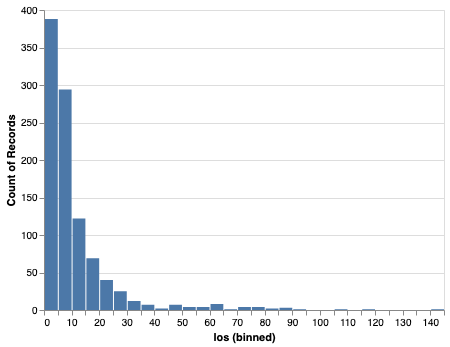

In [11]:
import altair as alt

alt.Chart(a_df.head(1000)).mark_bar().encode(
    alt.X('los',
         bin=alt.BinParams(maxbins=50)),
    y='count()',
)

In [24]:
notes_df = orig_df[orig_df.HADM_ID.notnull()].sample(frac=pct_data_sample, random_state=seed)
notes_df.HADM_ID = notes_df.HADM_ID.astype(int)
notes_df.shape

(185134, 11)

In [37]:
# make sure we only keep rows with notes
combined_df = pd.merge(a_df, notes_df, on='HADM_ID', how='right')

In [38]:
combined_df.shape

(185134, 16)

In [45]:
# these should all be zero
print(combined_df[combined_df.los.isnull()].shape)
print(combined_df[combined_df.HADM_ID.isnull()].shape)
print(combined_df[combined_df.TEXT.isnull()].shape)

(0, 16)
(0, 16)
(0, 16)


In [46]:
combined_df.head()

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0,754333,22,2196-04-09,2196-04-09 10:40:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2196-4-9**] 10:40 AM\n CHEST (PORTABLE AP) ...
1,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,2153-09-03 07:15:00,2153-09-08 19:10:00,5.0,1260822,23,2153-09-04,2153-09-04 14:02:00,2153-09-04 14:08:00,Nursing/other,Report,14606.0,NaN,UPDATE\nD: PT RECIEVED LOPRESSOR 25MG PO THIS ...
2,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,2153-09-03 07:15:00,2153-09-08 19:10:00,5.0,1260821,23,2153-09-04,2153-09-04 05:51:00,2153-09-04 06:12:00,Nursing/other,Report,14967.0,NaN,"CSRU NSG:\n\nNEURO: A&OX3, appropriate, speec..."
3,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,2157-10-18 19:34:00,2157-10-25 14:00:00,6.0,1099816,23,2157-10-21,2157-10-21 15:31:00,NaN,Radiology,CT HEAD W/O CONTRAST,NaN,NaN,[**2157-10-21**] 3:31 PM\n CT HEAD W/O CONTRAS...
4,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,2157-10-18 19:34:00,2157-10-25 14:00:00,6.0,1099545,23,2157-10-20,2157-10-20 07:28:00,NaN,Radiology,MR HEAD W/ CONTRAST,NaN,NaN,[**2157-10-20**] 7:28 AM\n MR HEAD W/ CONTRAST...
